In [3]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from random import sample
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print('Loading and Processing Data ...')
# df = pd.read_csv('../data/filtered_all.csv')
# df2 = df.groupby('user_screen_name').head(1000).reset_index(drop=True)
df2 = pd.read_csv('../data/media_10k_per.csv')
coor = pd.read_csv('../data/Media_coordinate.csv')

coor

def assign_coor(df, coor):
    media2bias = dict(zip(coor.Source, coor.Bias))
    df['bias'] = df['user_screen_name'].map(media2bias)
    df['bias'] = df['bias']/df['bias'].abs().max()
    media2qual = dict(zip(coor.Source, coor.Quality))
    df['quality'] = df['user_screen_name'].map(media2qual)
    df['quality'] = df['quality'] - df['quality'].abs().min()
    df['quality'] = df['quality']/df['quality'].abs().max()
    df = df.sample(frac=1,replace=True).reset_index(drop=True)

    return df
    
df = assign_coor(df2, coor)

articles = []
labels = []

for index, row in df.iterrows():
    labels.append(row[['bias','quality']])
    article = row['text']
    for word in STOPWORDS:
        token = ' ' + word + ' '
        article = article.replace(token, ' ')
        article = article.replace(' ', ' ')
    articles.append(article)
# print(len(labels))
# print(len(articles))
# print((articles[0],labels[0]))

print('Loading and Processing Data Complete!')
vocab_size = 5000
embedding_dim = 100
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
train_proportion = .5

train_size = int(len(articles) * train_proportion)
train_articles = articles[0: train_size]

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index


train_labels = labels[0: train_size]
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_articles = articles[train_size:]
validation_labels = labels[train_size:]
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_label_seq = np.array(train_labels).astype('float32')
validation_label_seq = np.array(validation_labels).astype('float32')

Loading and Processing Data ...
Loading and Processing Data Complete!


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 681,102
Trainable params: 681,102
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer='adam', loss="mse")
num_epochs = 5
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=1)

Train on 32063 samples, validate on 32064 samples
Epoch 1/5
32063/32063 [==============================] - 24s 733us/sample - loss: 0.0897 - val_loss: 0.0765
Epoch 2/5
32063/32063 [==============================] - 19s 582us/sample - loss: 0.0605 - val_loss: 0.0707
Epoch 3/5
32063/32063 [==============================] - 19s 586us/sample - loss: 0.0463 - val_loss: 0.0693
Epoch 4/5
32063/32063 [==============================] - 19s 587us/sample - loss: 0.0363 - val_loss: 0.0682
Epoch 5/5
32063/32063 [==============================] - 19s 587us/sample - loss: 0.0293 - val_loss: 0.0680


In [7]:
output = model.predict(validation_padded)
bias_pred = output[:,0]
qual_pred = output[:,1]
df_test = df[train_size:]
df_test['bias_pred'] = bias_pred
df_test['qual_pred'] = qual_pred


# coor = coor.sort_values(by = ['Source'])
average_bias = df_test.groupby(['user_screen_name']).bias_pred.mean()
average_qual = df_test.groupby(['user_screen_name']).qual_pred.mean()
bias = df_test.groupby(['user_screen_name']).bias.mean()
quality = df_test.groupby(['user_screen_name']).quality.mean()

corr_bias = scipy.stats.pearsonr(average_bias.tolist(), bias.tolist())[0]
corr_quality = scipy.stats.pearsonr(average_qual.tolist(), quality.tolist())[0]

print(corr_bias, corr_quality)

0.9732036194480771 0.9574087510206504


C:\Users\zchao\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\zchao\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


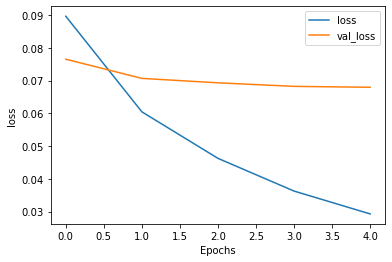

In [8]:
# STOP; Run all above
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "loss")

In [9]:
df2

,user_screen_name,text,bias,quality
0,ABC,Fidel Castro Dead at 90: Barbara Walters talks...,-0.071689,0.909878
1,ABC,Fidel Castro Dead at 90: Miami's Little Havana...,-0.071689,0.909878
2,ABC,World leaders from Justin Trudeau to Vladimir ...,-0.071689,0.909878
3,ABC,World leaders and public figures react to form...,-0.071689,0.909878
4,ABC,Fidel Castro's funeral set for December 4 foll...,-0.071689,0.909878
...,...,...,...,...
64122,Bloomberg,Pride in Action means creating an inclusive sp...,-0.033023,0.818936
64123,Bloomberg,Why retail's brick-and-mortar design still has...,-0.033023,0.818936
64124,Bloomberg,Path to India reforms eased as Modi turns enem...,-0.033023,0.818936
64125,Bloomberg,"New year, new regulations as MiFID II and PRII...",-0.033023,0.818936


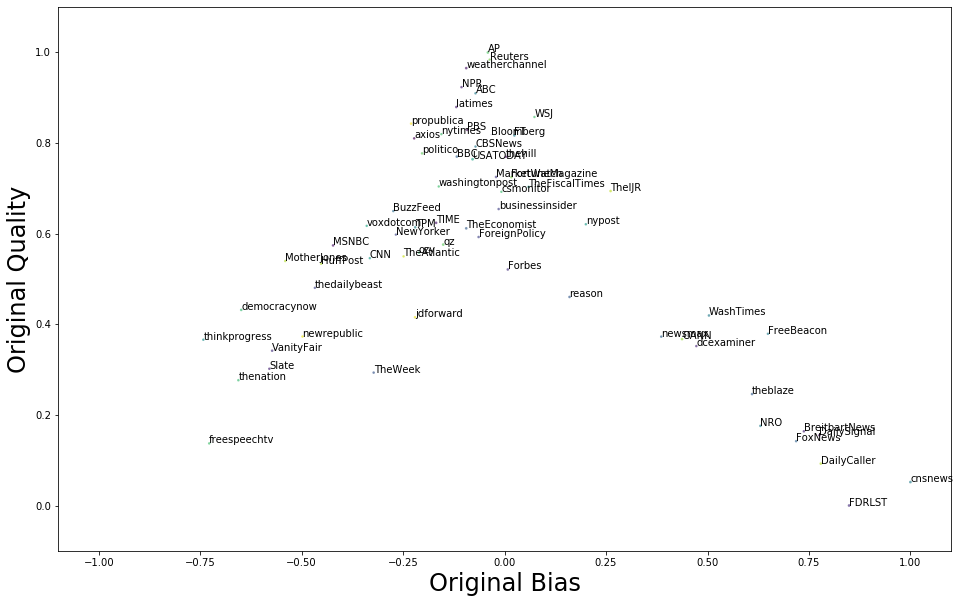

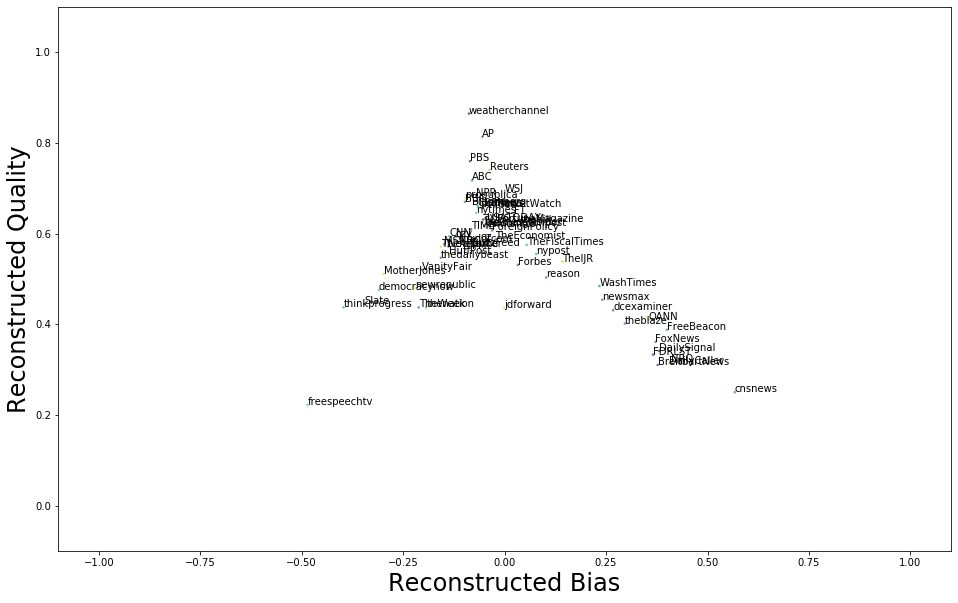

In [10]:
n_tweets = df_test.groupby(['user_screen_name']).size()
n_tweets = n_tweets.rename("n_tweets")
media_bias = coor
N = media_bias.shape[0]
np.random.seed(1)
colors = np.random.rand(N)
media_bias = media_bias.set_index('Source').join(average_bias).join(average_qual).join(n_tweets)
media_bias = media_bias.dropna()
media_bias = media_bias.reset_index()
max_abs_bias = media_bias.Bias.abs().max()
min_qual = media_bias.Quality.min()
max_qual = media_bias.Quality.max()-min_qual

def plotposition(names, dir1, dir2):
    index = media_bias.Source.isin(names)

    names = media_bias[index].Source.tolist()
    x0 = [x/max_abs_bias for x in media_bias[index].Bias.tolist()]
    y0 = [(x-min_qual)/max_qual for x in media_bias[index].Quality.tolist()]
    x1 = media_bias[index].bias_pred.tolist()
    y1 = media_bias[index].qual_pred.tolist()
    size = [x**2 / 90000 for x in media_bias[index].n_tweets.tolist()]
    color = pd.Series(colors)[index].tolist()
    
    plt.figure(figsize=(16, 10))
    # pd.Series(size)
    plt.scatter(x0, y0, s=size, c=color, alpha=0.5)
    for i, name in enumerate(names):
        plt.annotate(name, (x0[i], y0[i]))
    plt.xlim(-1.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Original Bias', fontsize=24)
    plt.ylabel('Original Quality', fontsize=24)
    plt.savefig(dir1)
    

    plt.figure(figsize=(16, 10))
    for i, name in enumerate(names):
        plt.annotate(name, (x1[i], y1[i]))
    plt.scatter(x1, y1, s=size, c=color, alpha=0.5)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Reconstructed Bias', fontsize=24)
    plt.ylabel('Reconstructed Quality', fontsize=24)
    plt.savefig(dir2)

names = media_bias.Source.tolist()
dir1 = '../results/LSTM/media_all_origin.png'
dir2 = '../results/LSTM/media_all_recon.png'
plotposition(names, dir1, dir2)

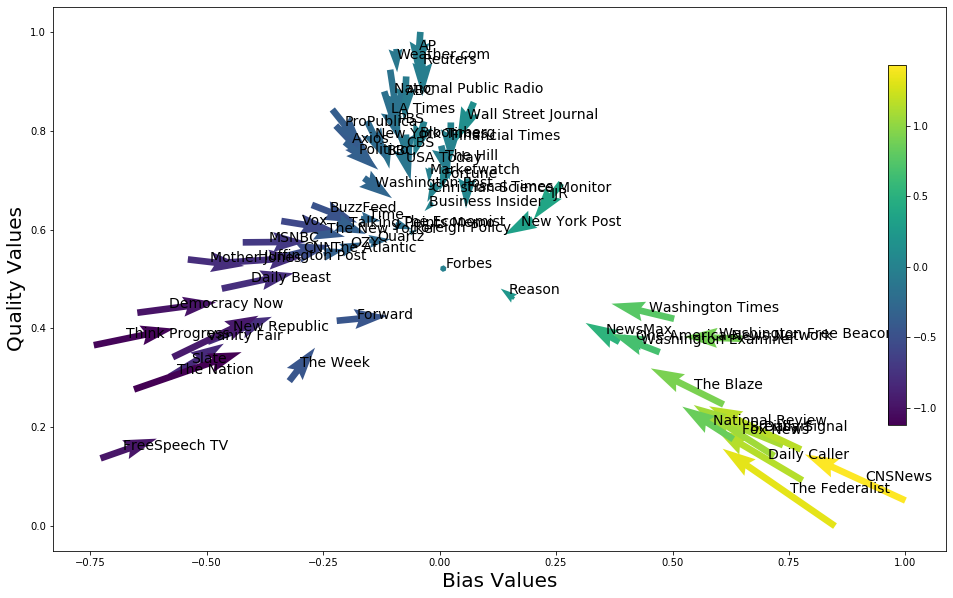

<Figure size 1152x720 with 0 Axes>

In [46]:
# %matplotlib widget

names = media_bias.Source.tolist()
index = media_bias.Source.isin(names)

x0 = media_bias[index].Bias
x0 = x0/x0.abs().max()
y0 = media_bias[index].Quality
y0 = y0-y0.abs().min()
y0 = y0/y0.abs().max()
x1 = media_bias[index].bias_pred - x0
y1 = media_bias[index].qual_pred - y0

color = x0-x1
# fig, ax = plt.subplots(figsize = (16, 10))
# ax.quiver(x0, y0, x1, y1, color)
# ax.set_xlabel('Bias Values',fontsize=20)
# ax.set_ylabel('Quality Values',fontsize=20)
# for i, name in enumerate(names):
#     plt.text(x0[i]+0.2*x1[i], y0[i]+0.2*y1[i] , Tweet_to_AFMBC[name], fontsize=14,picker=True)
# # dragh = DragHandler()
# cax = plt.axes([0.875, 0.3, 0.015, 0.55])

# plt.colorbar(quiver(x0, y0, x1, y1, color), cax=cax)
# plt.imshow()
# dir = '../results/LSTM/media_shift.png'
# plt.savefig(dir)
plt.rcParams["figure.figsize"] = (16,10)
plt.quiver(x0, y0, x1, y1, color)
plt.xlabel('Bias Values',fontsize=20)
plt.ylabel('Quality Values',fontsize=20)
for i, name in enumerate(names):
    plt.text(x0[i]+0.2*x1[i], y0[i]+0.2*y1[i] , Tweet_to_AFMBC[name], fontsize=14,picker=True)
# dragh = DragHandler()
cax = plt.axes([0.85, 0.3, 0.015, 0.55])

plt.colorbar(cax=cax)
plt.show()
dir = '../results/LSTM/media_shift.png'
plt.savefig(dir)

In [ ]:
y1.describe()

In [14]:
MediaBiasChart_to_Tweet = {'ABC':'ABC','AP':'AP','Axios':'axios','CNN':'CNN','Wall Street Journal':'WSJ',\
    'The Atlantic':'TheAtlantic','The Hill':'thehill', 'BBC':'BBC', 'Think Progress':'thinkprogress',\
    'MSNBC':'MSNBC','The Nation':'thenation','Daily Beast':'thedailybeast','Mother Jones':'MotherJones',\
    'CNSNews':'cnsnews','Fox News':'FoxNews', 'The Federalist':'FDRLST','Breitbart':'BreitbartNews',\
    'Daily Caller':'DailyCaller','The Blaze':'theblaze','Business Insider':'businessinsider',\
    'CBS':'CBSNews','The Economist':'TheEconomist','BuzzFeed':'BuzzFeed','Daily Signal':'DailySignal',\
    'New Republic':'newrepublic','Foreign Policy':'ForeignPolicy','IJR':'TheIJR','National Review':'NRO',\
    'National Public Radio':'NPR','New York Post':'nypost','New York Times':'nytimes','The New Yorker':'NewYorker',\
    'NewsMax':'newsmax','One America News Network':'OANN','Politico':'politico','Quartz':'qz',\
    'Reason':'reason','Reuters':'Reuters','Slate':'Slate','Talking Points Memo':'TPM','Vanity Fair':'VanityFair',\
    'Vox':'voxdotcom','Washington Examiner':'dcexaminer','Washington Free Beacon':'FreeBeacon',\
    'Washington Post':'washingtonpost','Washington Times':'WashTimes','The Week':'TheWeek','Bloomberg':'Bloomberg',\
    'Christian Science Monitor':'csmonitor', 'Democracy Now':'democracynow','Financial Times':'FT',\
    'Fiscal Times':'TheFiscalTimes','Forbes':'Forbes','Fortune':'FortuneMagazine','Forward':'jdforward',\
    'FreeSpeech TV':'freespeechtv','Huffington Post':'HuffPost','LA Times':'latimes','Marketwatch':'MarketWatch',\
    'OZY':'ozy','PBS':'PBS','ProPublica':'propublica','Time':'TIME','USA Today':'USATODAY',\
    'Weather.com':'weatherchannel'}

Tweet_to_AFMBC = {v: k for k, v in MediaBiasChart_to_Tweet.items()}

In [ ]:
from matplotlib         import pylab as p
from matplotlib.text import Text

class DragHandler(object):
    """ A simple class to handle Drag n Drop.

    This is a simple example, which works for Text objects only
    """
    def __init__(self, figure=None) :
        """ Create a new drag handler and connect it to the figure's event system.
        If the figure handler is not given, the current figure is used instead
        """

        if figure is None : figure = p.gcf()
        # simple attibute to store the dragged text object
        self.dragged = None

        # Connect events and callbacks
        figure.canvas.mpl_connect("pick_event", self.on_pick_event)
        figure.canvas.mpl_connect("button_release_event", self.on_release_event)

    def on_pick_event(self, event):
        " Store which text object was picked and were the pick event occurs."

        if isinstance(event.artist, Text):
            self.dragged = event.artist
            self.pick_pos = (event.mouseevent.xdata, event.mouseevent.ydata)
        return True

    def on_release_event(self, event):
        " Update text position and redraw"

        if self.dragged is not None :
            old_pos = self.dragged.get_position()
            new_pos = (old_pos[0] + event.xdata - self.pick_pos[0],
                       old_pos[1] + event.ydata - self.pick_pos[1])
            self.dragged.set_position(new_pos)
            self.dragged = None
            p.draw()
        return True